# Example Scenario

This notebook contains an example setup to run experiments as done in the [paper](https://arxiv.org/abs/2004.07641).

As we are in the process of significantly refactoring the code base and experiments, we did not update the entire experiment notebook done to reproduce the paper experiments, as they are now deprecated.

__If you want to play around and reproduce results currently shown in the arXiv paper, revert to commit__
`062f03bd809a5df3db7158e4075f855ce110dfcc`

The notebook is organized as follows:

* In Section 1, we define all the simulation parameters.
* In Section 2, we run all the simulations needed for the experiment.
* In Section 3, we plot the results.

To just regenerate the figures from a summary file containing all the simulation objects of the experiment, you can skip Section 2, and only run the cells in Sections 1 & 3. 

---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
%load_ext autoreload
%autoreload 2
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (MeasureList, Interval,
                          BetaMultiplierMeasureByType,
                          SocialDistancingForAllMeasure, 
                          SocialDistancingForPositiveMeasure,
                          SocialDistancingForPositiveMeasureHousehold)
from lib.inference import gen_initial_seeds, extract_seeds_from_summary
from lib.plot import Plotter
import matplotlib.pyplot as plt
%matplotlib inline

# converting days to hours
TO_HOURS = 24.0

#### Set the random seed for reproducibility

In [3]:
# Choose random seed
c = 0
# Set it
np.random.seed(c)
# Define prefix string used to save plots
runstr = f'run{c}_'

#### Set the number of roll-outs to simulate

In [4]:
random_repeats = 4 # Set to at least 40 to obtain stable results

#### Define the number of parallel workers used for simulations 

In [5]:
num_workers = multiprocessing.cpu_count() - 1

#### Set the time to simulate

In [6]:
start_date = '2020-03-10'
end_date = '2020-03-23'
sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
max_time = TO_HOURS * sim_days # in hours

#### Define population/mobility parameters

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

Check out `lib/mobility/` and `lib/settings/` for all pre-generated towns in Germany and Switzerland. 

In [7]:
case_downsample = 10                                
mob_settings = 'lib/mobility/Tubingen_settings_10_10_hh.pk'  
area = 'TU'
country = 'GER'

# See town-generator.ipynb for an example on how to create the settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)

#### Load the case data

Adjust the number of cases to the down-scaling of the population

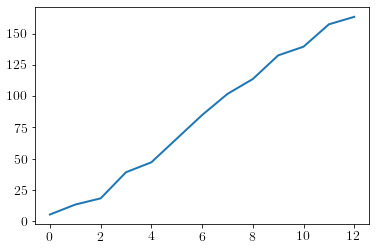

In [8]:
new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
    start_date_string=start_date, end_date_string=end_date)
new_cases = np.ceil(1/case_downsample * new_cases_)

plt.plot(new_cases_.sum(1));

#### Instantiate correct state transition distributions (estimated from in literature)

In [9]:
distributions = CovidDistributions(country=country)

#### Define helper I/O functions to load/save the output of the experiment

In [10]:
def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

#### Define initial seed count per state 


In [11]:
heuristic_seeds = True

# (a) define heuristically based on true cases and literature distribution estimates
if heuristic_seeds:
    initial_seeds = gen_initial_seeds(new_cases)

# (b) define based state of previous batch of simulations, 
# using the random rollout that best matched the true cases in terms of squared error
else:
    seed_summary_ = load_summary('summary_example.pk')
    seed_day_ = 7
    initial_seeeds = extract_seeds_from_summary(seed_summary_, seed_day_, new_cases)

#### Set epidemic parameters

Calibrated using Bayesian optimization.

In [12]:
beta = 1.50 # this needs to be calibrated

inferred_params = {
    'betas' : {
        'education': beta,
        'social': beta,
        'bus_stop': beta,
        'office': beta,
        'supermarket': beta}, 
    'beta_household' : beta
}

#### Define standard testing parameters

The parameters are the same used for inference.

In [13]:
def standard_testing(max_time):
    daily_increase = new_cases.sum(axis=1)[1:] - new_cases.sum(axis=1)[:-1]
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 1 * TO_HOURS,     # in hours
        'test_reporting_lag'  : 2 * TO_HOURS,     # in hours (actual and self-report delay)
        'tests_per_batch'     : int(daily_increase.max()), # test capacity based on empirical positive tests
        'test_fpr'            : 0.0, # test false positive rate
        'test_fnr'            : 0.0, # test false negative rate
        'test_smart_delta'    : 3 * TO_HOURS, # in hours
        'test_smart_duration' : 7 * TO_HOURS, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

---

## 2. Run the simulations

Define a helper function to run general type of experiment, fixing all parameters above.

In [14]:
def run(tparam, measure_list, t, local_seeds, dynamic_tracing=False):

    # add standard measure of positives staying isolated
    measure_list +=  [
        SocialDistancingForPositiveMeasure(
            t_window=Interval(0.0, t), p_stay_home=1.0),
        
        SocialDistancingForPositiveMeasureHousehold(
            t_window=Interval(0.0, t), p_isolate=1.0)
    ]
    measure_list = MeasureList(measure_list)

    # run simulations
    summary = launch_parallel_simulations(
        mob_settings, 
        distributions, 
        random_repeats, num_workers, 
        inferred_params, local_seeds, tparam, measure_list, 
        max_time=t, 
        num_people=mob.num_people, 
        num_sites=mob.num_sites, 
        site_loc=mob.site_loc, 
        home_loc=mob.home_loc,
        dynamic_tracing=dynamic_tracing,
        verbose=False)
    return summary
    

#### Define Measures to take place during simulation

In [15]:
lockdown_at_day = 7

example_measures = [
    
    # education, social sites, and offices close after 1 week
    BetaMultiplierMeasureByType(
        t_window=Interval(lockdown_at_day * TO_HOURS, max_time), 
        beta_multiplier={ 
            'education': 0.0, 
            'social': 0.0, 
            'bus_stop': 1.0, 
            'office': 0.0, 
            'supermarket': 1.0
        }),
    
    # less activities of all due to contact constraints after 1 week
    SocialDistancingForAllMeasure(
     t_window=Interval(lockdown_at_day * TO_HOURS, max_time), 
        p_stay_home=0.5)
    
    # see measures.py for other options
]


Run the experiment using the parameters defined above and simulate in the future, with additional measures of varying duration.

**WARNING: this cell might take a long time to run depending of the parameters defined above!**

In [16]:
testing_params = standard_testing(max_time)
summary_example = run(testing_params, example_measures, max_time, initial_seeds)
save_summary(summary_example, 'summary_example.pk')

## 3. Plot the results

Load the summary holding the results of the experiment to plot.

In [17]:
summary_example = load_summary('summary_example.pk')

Example plot (a)

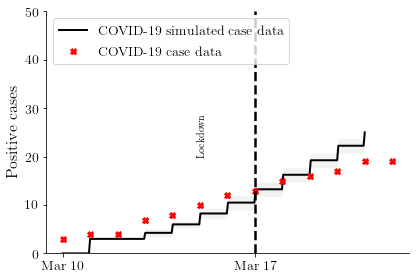

In [18]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_example, new_cases.sum(axis=1), 
    test_lag=2,
    title='Predictions for observed controlled scenario after March 23', 
    filename=runstr + 'ex_00',
    figsize=(6, 4),
    start_date=start_date,
    errorevery=1, acc=1000, 
    lockdown_at=lockdown_at_day,
    ymax=50)


Example plot (b)

Optimize sigma using maximum likelihood estimation...
 0.50: 3
 0.50: 3
 0.01: 3
 0.01: 3
done. Best sigma found at: 0.01


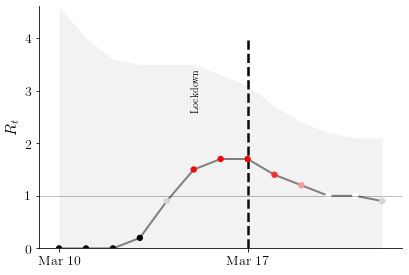

In [19]:
plotter = Plotter()
plotter.plot_daily_rts(
    summary_example,
    filename=runstr + 'ex_01',
    start_date=start_date,
    sigma=None,
    figsize=(6, 4), 
    subplot_adjust=None,
    lockdown_label='Lockdown', 
    lockdown_at=lockdown_at_day,
    lockdown_label_y=2.6,
    ymax=4.0)

Example plot (c)

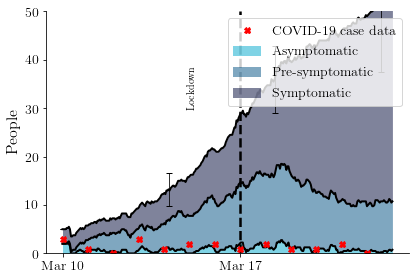

In [20]:
targets = new_cases.sum(axis=1)
targets = np.hstack((targets[0], np.diff(targets)))

plotter = Plotter()
plotter.plot_daily_infected(
    summary_example,
    title='', 
    filename=runstr + 'ex_02',
    errorevery=100, acc=1000, 
    figsize=(6, 4),
    start_date=start_date,
    show_target=targets,
    lockdown_at=lockdown_at_day,
    lockdown_label_y=30,
    lockdown_label='Lockdown',
    ymax=50)

Example plot (d)

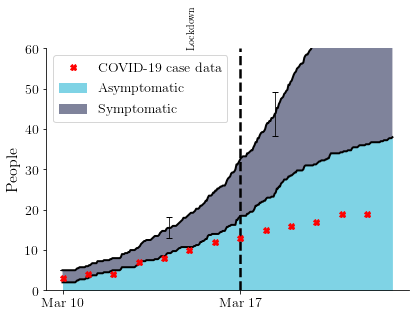

In [21]:
plotter = Plotter()
plotter.plot_cumulative_infected(
    summary_example,
    title='', 
    filename=runstr + 'ex_03',
    figsize=(6, 4),
    legend_loc='upper left',
    errorevery=100, acc=1000, 
    start_date=start_date,
    lockdown_at=lockdown_at_day,
    lockdown_label_y=60,
    show_target=new_cases.sum(axis=1),
    ymax=60)